In [64]:
!pip install yfinance
!pip install mplfinance

In [65]:
import pandas as pd
from pandas_datareader import data as web
import yfinance as yf
yf.pdr_override()
import mplfinance as mpf
import numpy as np

In [66]:
start = '2020-01-01'
end = '2021-01-01'

In [67]:
data = web.get_data_yahoo('SPY', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [68]:
def macd_func(df, a=12, b=21, c=9):
    # MACD
    EMA_short = df['Close'].ewm(span=a, adjust=False, min_periods = a+1).mean()
    EMA_long = df['Close'].ewm(span=b, adjust=False, min_periods = b+1).mean()
    MACD = EMA_short - EMA_long
    signal = MACD.ewm(span=c, adjust=False, min_periods = c+1).mean()
    df['macd'] = MACD
    df['signal_line'] = signal
    df['histogram'] = df['macd'] - df['signal_line']
    # Find entry point
    df['shift_hist'] = df['histogram'].shift(1)
    df[(df['histogram'] > 0) & (df['shift_hist'] < 0)]
    df.loc[(df['histogram'] > 0) & (df['shift_hist'] < 0), 'action'] = 'buy'
    df.loc[(df['histogram'] < 0) & (df['shift_hist'] > 0), 'action'] = 'sell'
    df.loc[df['action'] == 'buy', 'marker_position'] = df['Low'] * 0.98
    df.loc[df['action'] == 'sell', 'marker_position'] = df['High'] * 1.02
    return df

In [69]:
macd_data = macd_func(data)

In [70]:
macd_data[macd_data['action'] == 'buy']

,Open,High,Low,Close,Adj Close,Volume,macd,signal_line,histogram,shift_hist,action,marker_position
Date,,,,,,,,,,,,
2020-03-26,249.520004,262.799988,249.050003,261.200012,254.526550,257632800,-13.167172,-14.109464,0.942292,-0.801604,buy,244.069003
2020-05-08,291.089996,292.950012,289.859985,292.440002,284.968414,76452400,3.351353,3.205144,0.146209,-0.051595,buy,284.062786
2020-05-20,295.820007,297.869995,295.570007,296.929993,289.343658,85861700,2.911528,2.739869,0.171659,-0.117488,buy,289.658607
2020-07-07,315.380005,317.519989,313.369995,313.779999,307.108704,82910000,1.597584,1.538234,0.059350,-0.040492,buy,307.102595
2020-08-03,328.320007,329.619995,327.730011,328.790009,321.799591,53077900,2.682243,2.653434,0.028809,-0.112964,buy,321.175411
2020-08-24,342.119995,343.000000,339.450012,342.920013,335.629181,48588700,3.491134,3.465624,0.025510,-0.102386,buy,332.661012
2020-10-01,337.690002,338.739990,335.010010,337.040009,331.194641,88698700,-1.122773,-1.414951,0.292177,-0.068376,buy,328.309810
2020-11-05,349.239990,352.190002,348.859985,350.239990,344.165710,82039700,-0.085057,-0.476301,0.391244,-0.439694,buy,341.882786


In [71]:
def macd_plot(df_plot):
    df = macd_func(df_plot)
    # For plot MACD
    mpf_macd = mpf.make_addplot(df['macd'], panel=1, color='blue', title='MACD')
    mpf_signal = mpf.make_addplot(df['signal_line'], panel=1, color='orange')
    
    colors = ['green' if value >= 0 else 'red' for value in df['histogram']]
    mpf_histogram = mpf.make_addplot(df['histogram'], type='bar', panel=1, color=colors)
    
    # For marker
    markers = ['^' if x == 'buy' else 'v' for x in df['action']]
    color_marker = ['green' if x == 'buy' else 'red' for x in df['action']]
    plot_signal = mpf.make_addplot(df['marker_position'], type='scatter', markersize=30, marker=markers, color=color_marker)
    
    plots = [mpf_macd, mpf_signal, mpf_histogram, plot_signal]
    
    return plots

In [72]:
a = macd_plot(data)

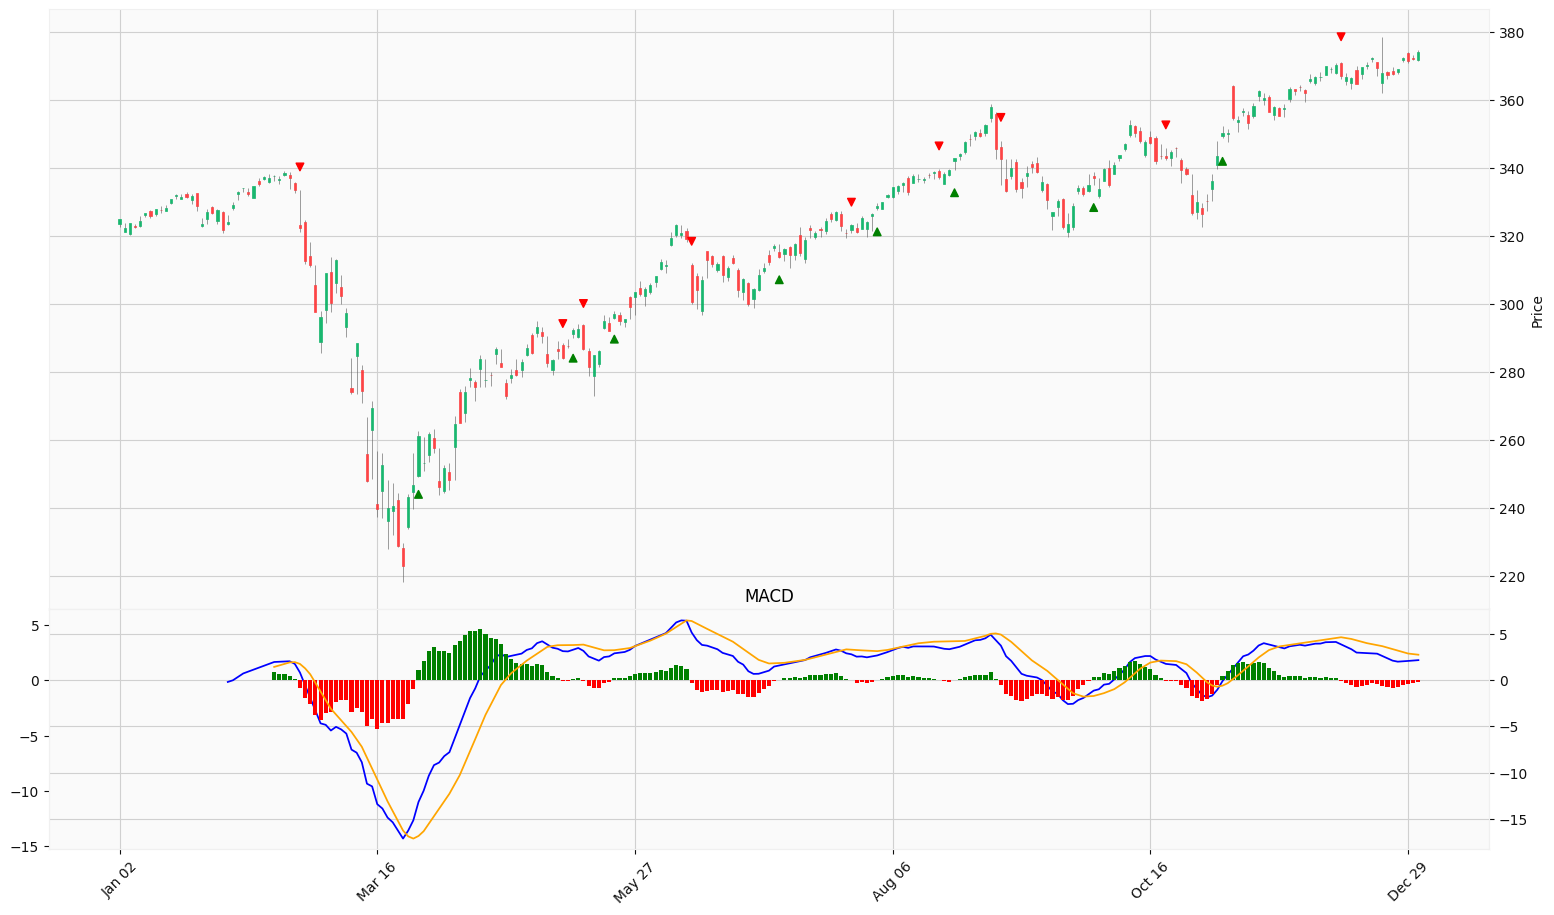

In [73]:
mpf.plot(data, type='candle', style='yahoo', addplot=a, figsize=(20, 12))

In [74]:
test = macd_data.copy()

In [75]:
test.head()

,Open,High,Low,Close,Adj Close,Volume,macd,signal_line,histogram,shift_hist,action,marker_position
Date,,,,,,,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,314.719147,59151200,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,321.160004,323.640015,321.100006,322.410004,312.336090,77709700,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,320.489990,323.730011,320.359985,323.640015,313.527649,55653900,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,323.019989,323.540009,322.239990,322.730011,312.646088,40496400,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,322.940002,325.779999,322.670013,324.450012,314.312317,68296000,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
test['action_price'] = test['Open'].shift(-1)

In [77]:
test.head()

,Open,High,Low,Close,Adj Close,Volume,macd,signal_line,histogram,shift_hist,action,marker_position,action_price
Date,,,,,,,,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,314.719147,59151200,NaN,NaN,NaN,NaN,NaN,NaN,321.160004
2020-01-03,321.160004,323.640015,321.100006,322.410004,312.336090,77709700,NaN,NaN,NaN,NaN,NaN,NaN,320.489990
2020-01-06,320.489990,323.730011,320.359985,323.640015,313.527649,55653900,NaN,NaN,NaN,NaN,NaN,NaN,323.019989
2020-01-07,323.019989,323.540009,322.239990,322.730011,312.646088,40496400,NaN,NaN,NaN,NaN,NaN,NaN,322.940002
2020-01-08,322.940002,325.779999,322.670013,324.450012,314.312317,68296000,NaN,NaN,NaN,NaN,NaN,NaN,326.160004


In [78]:
test_record = test[test.action.notnull()]
test_record['return'] = test_record['action_price'].pct_change(1)
test_record.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,High,Low,Close,Adj Close,Volume,macd,signal_line,histogram,shift_hist,action,marker_position,action_price,return
Date,,,,,,,,,,,,,,
2020-02-24,323.140015,333.559998,321.239990,322.420013,312.345734,161088400,0.835725,1.493476,-0.657751,0.114901,sell,340.231198,323.940002,NaN
2020-03-26,249.520004,262.799988,249.050003,261.200012,254.526550,257632800,-13.167172,-14.109464,0.942292,-0.801604,buy,244.069003,253.270004,-0.218158
2020-05-06,288.040009,288.459991,283.779999,284.250000,276.987640,73632600,3.145115,3.181491,-0.036375,0.214537,sell,294.229191,287.750000,0.136139
2020-05-08,291.089996,292.950012,289.859985,292.440002,284.968414,76452400,3.351353,3.205144,0.146209,-0.051595,buy,284.062786,290.339996,0.009001
2020-05-12,293.790009,294.239990,286.519989,286.670013,279.345825,95870800,3.178340,3.245125,-0.066785,0.226710,sell,300.124790,286.059998,-0.014741


In [79]:
test_record.reset_index(inplace=True)
test_record.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'macd',
       'signal_line', 'histogram', 'shift_hist', 'action', 'marker_position',
       'action_price', 'return'],
      dtype='object')

In [80]:
test_record['previous_signal_date'] = test_record['Date'].shift(1)
test_record['previous_action'] = test_record['action'].shift(1)
test_record['previous_action_price'] = test_record['action_price'].shift(1)
test_record.rename(columns={'Date' : 'today_signal_date'}, inplace=True)

test_record.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,today_signal_date,Open,High,Low,Close,Adj Close,Volume,macd,signal_line,histogram,shift_hist,action,marker_position,action_price,return,previous_signal_date,previous_action,previous_action_price
0,2020-02-24,323.140015,333.559998,321.239990,322.420013,312.345734,161088400,0.835725,1.493476,-0.657751,0.114901,sell,340.231198,323.940002,NaN,NaT,NaN,NaN
1,2020-03-26,249.520004,262.799988,249.050003,261.200012,254.526550,257632800,-13.167172,-14.109464,0.942292,-0.801604,buy,244.069003,253.270004,-0.218158,2020-02-24,sell,323.940002
2,2020-05-06,288.040009,288.459991,283.779999,284.250000,276.987640,73632600,3.145115,3.181491,-0.036375,0.214537,sell,294.229191,287.750000,0.136139,2020-03-26,buy,253.270004
3,2020-05-08,291.089996,292.950012,289.859985,292.440002,284.968414,76452400,3.351353,3.205144,0.146209,-0.051595,buy,284.062786,290.339996,0.009001,2020-05-06,sell,287.750000
4,2020-05-12,293.790009,294.239990,286.519989,286.670013,279.345825,95870800,3.178340,3.245125,-0.066785,0.226710,sell,300.124790,286.059998,-0.014741,2020-05-08,buy,290.339996


In [81]:
test_record = test_record[['action', 'today_signal_date', 'action_price', 'return', 'previous_signal_date', 'previous_action', 'previous_action_price']]
test_record.head()

,action,today_signal_date,action_price,return,previous_signal_date,previous_action,previous_action_price
0,sell,2020-02-24,323.940002,NaN,NaT,NaN,NaN
1,buy,2020-03-26,253.270004,-0.218158,2020-02-24,sell,323.940002
2,sell,2020-05-06,287.750000,0.136139,2020-03-26,buy,253.270004
3,buy,2020-05-08,290.339996,0.009001,2020-05-06,sell,287.750000
4,sell,2020-05-12,286.059998,-0.014741,2020-05-08,buy,290.339996


In [82]:
profit = test_record[test_record.action == 'sell']

In [83]:
profit

,action,today_signal_date,action_price,return,previous_signal_date,previous_action,previous_action_price
0,sell,2020-02-24,323.940002,NaN,NaT,NaN,NaN
2,sell,2020-05-06,287.750000,0.136139,2020-03-26,buy,253.270004
4,sell,2020-05-12,286.059998,-0.014741,2020-05-08,buy,290.339996
6,sell,2020-06-11,308.239990,0.038579,2020-05-20,buy,296.790009
8,sell,2020-07-27,322.429993,0.024856,2020-07-07,buy,314.609985
10,sell,2020-08-19,335.359985,0.022876,2020-08-03,buy,327.859985
12,sell,2020-09-04,336.709991,-0.019853,2020-08-24,buy,343.529999
14,sell,2020-10-21,342.959991,0.033946,2020-10-01,buy,331.700012
16,sell,2020-12-09,365.369995,0.044123,2020-11-05,buy,349.929993


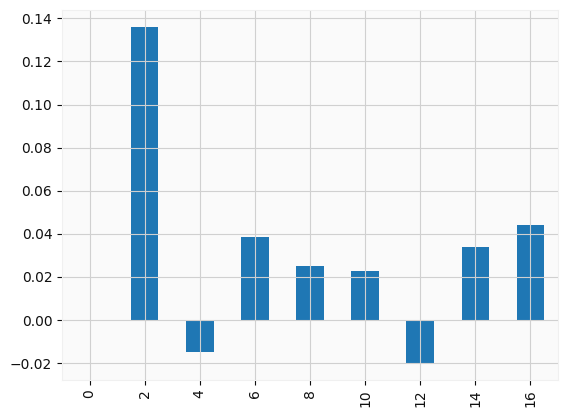

In [84]:
profit['return'].plot(kind='bar')